In [1]:
# modules
from imports import np, plt, iio, cv2, gaussian, Path, gf, filters, data, fusion, recalage

# functions
from imports import gray_to_rgb, plot_images

# variables
from imports import BASE_DIR, multi_exposure_dataset, multi_focus_dataset, ours_dataset, multi_exposure_sample, multi_exposure_sample, multi_focus_sample, ours_sample, gray_sample

# Image fusion with guided filtering

The method aims at combining several images, either in a multi-focus setting or in a multi-exposure setting.

```{tip}
:class: margin
**Saliency** is defined as the local average of the norm of the image Laplacian.
```


The images are combined through a weighted sum. The weights are determined according to the saliency map of each image, which measures the level of spatial variation at each pixel. In addition, the method aims at leveraging structural information, especially by preserving edges as much as possible thanks to guided filtering.

This method can be used indifferently for multi-focus and multi-exposure problems because in both cases, the saliency map is a relevant quantity. Indeed, in the multi-focus setting, images are salient where they are sharp, whereas in the multi-exposure setting they are salient where they are well-exposed.

![image_fusion_schematic.png](images/image_fusion_schematic.png)

## Step by step

In [2]:
gff_focus = fusion.gff(multi_focus_sample)

### Weight map
Weight maps are constructed to be $1$ at pixel $i$ if the image has the highest saliency (i.e. gradient norm) at pixel $i$, and $0$ otherwise.

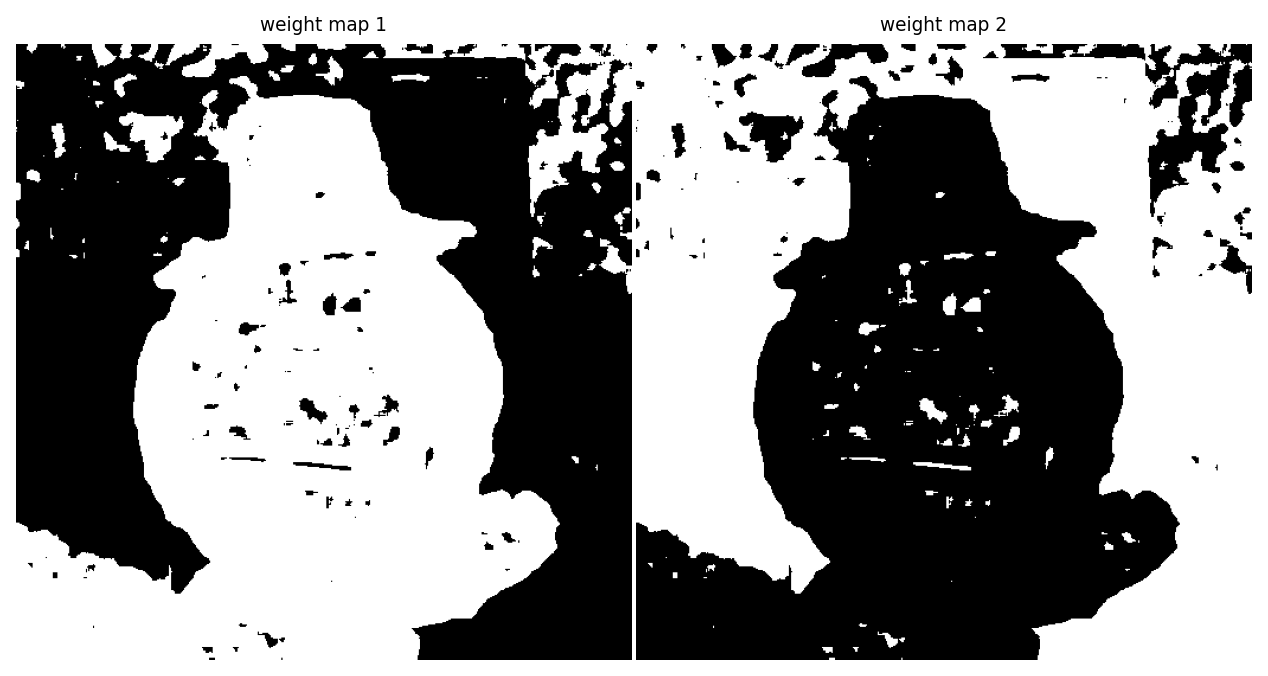

In [3]:
plot_images(*gff_focus.weights,
            labels=['weight map 1', 'weight map 2'])
plt.show()

### Base / Detail decomposition
Then, images are split into a base layer and a detail layer. Each layer will have its own weight map and be fused back in only at the very end.

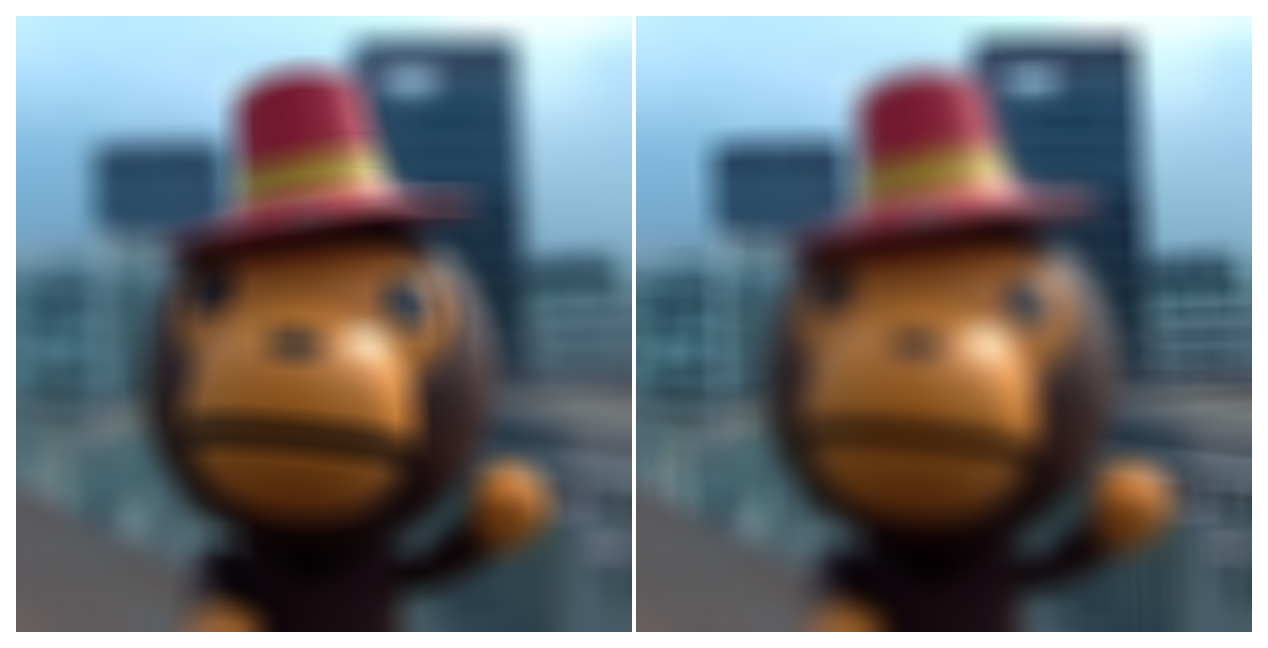

In [4]:
base_layer, detail_layer = zip(*[gff_focus.decompose(im) for im in gff_focus.ims])
plot_images(*base_layer)
plt.show()

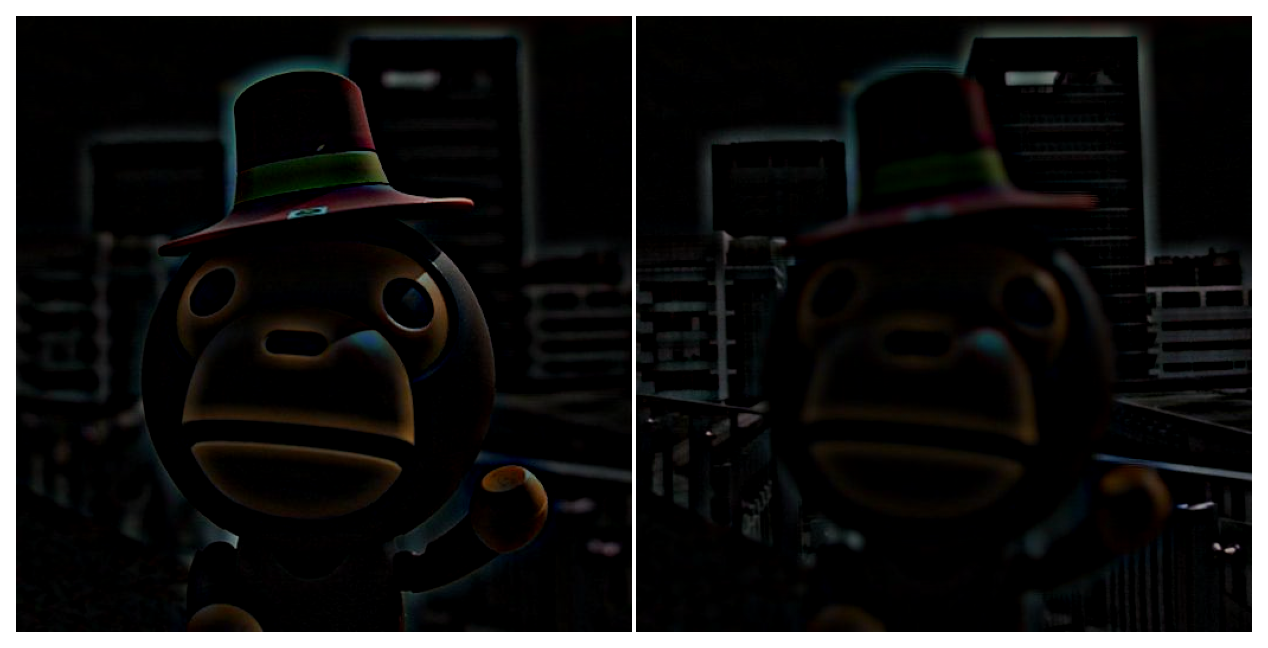

In [5]:
plot_images(*detail_layer)
plt.show()

### Refined weight map
The key idea is to use guided filtering with the original image as guidance. This mitigates noise and edge-aligns weight maps.

Different parameters (see below) are used to get distinct weight maps for the base and details layers. In general, a larger window size, and a larger regularisation $\varepsilon$ are used for the base layer.

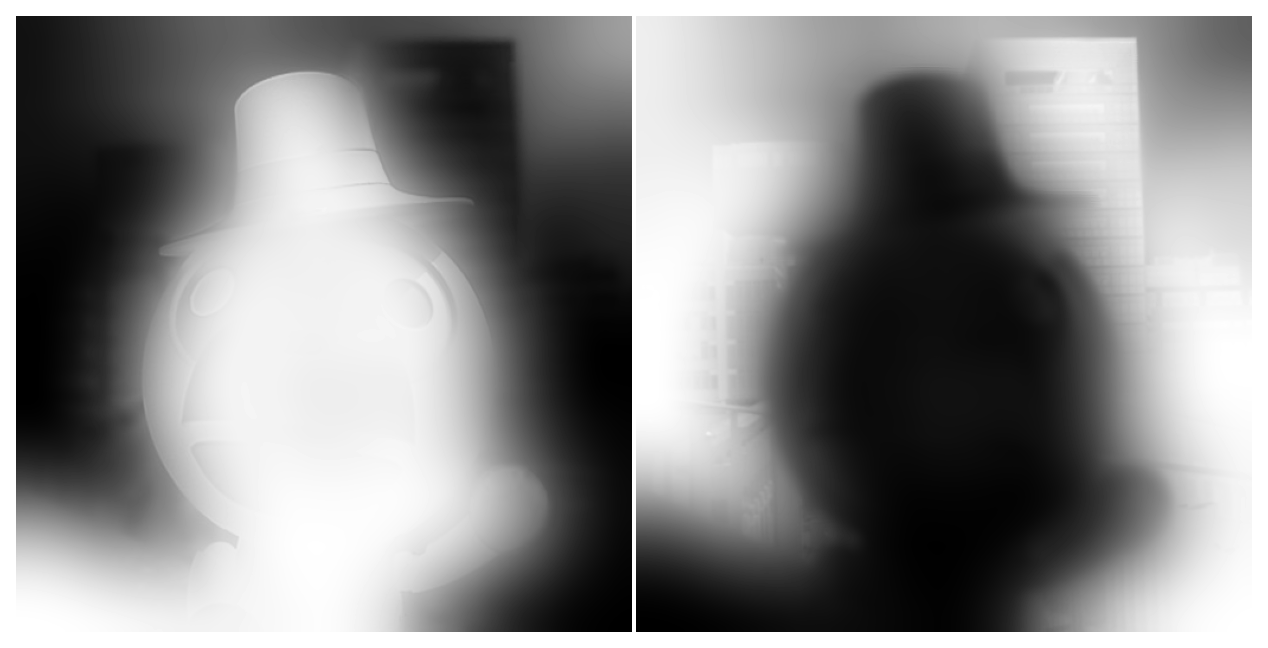

In [6]:
fused_focus = gff_focus.fusion()
plot_images(*gff_focus.refined_weights["base"])
plt.show()

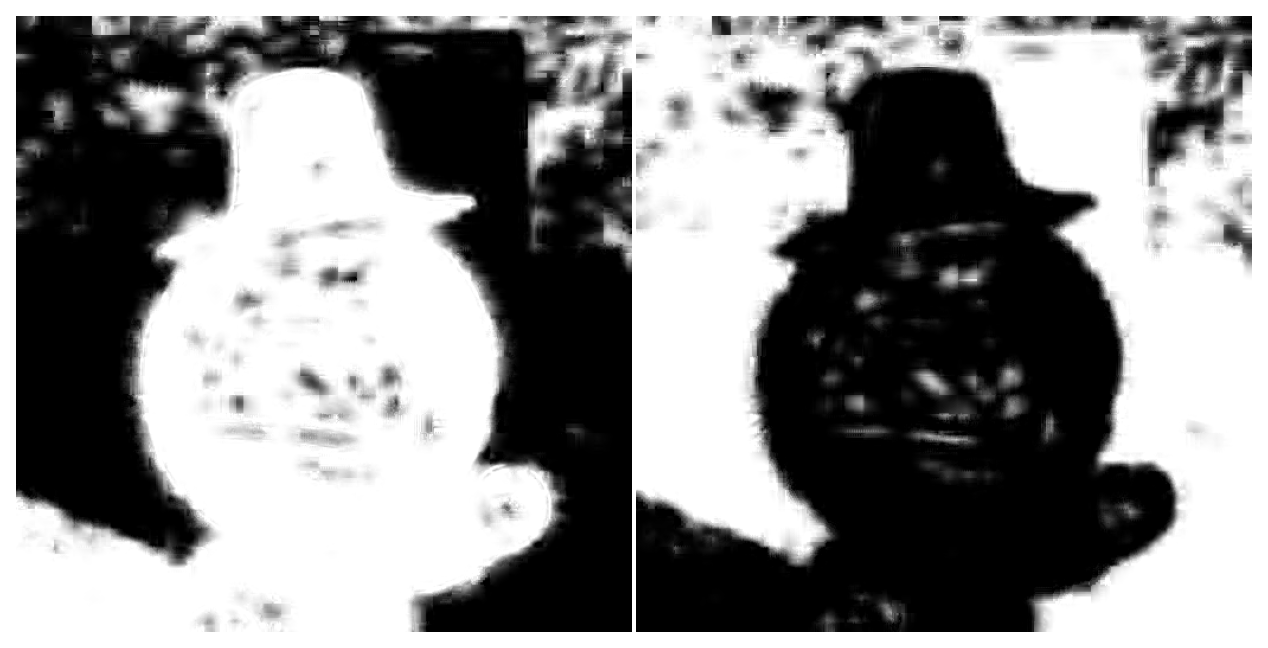

In [7]:
plot_images(*gff_focus.refined_weights["detail"])
plt.show()

### Fusion
Those refined weight maps are used to fuse images in each layer base and details). Finally, the layers are added up to produce a single final image.
For multi-focus, the base fusion is not that important as the base images basically look the same (a blurry version of the scene). However, for HDR, both base fusion and detail fusion must be done carefully.

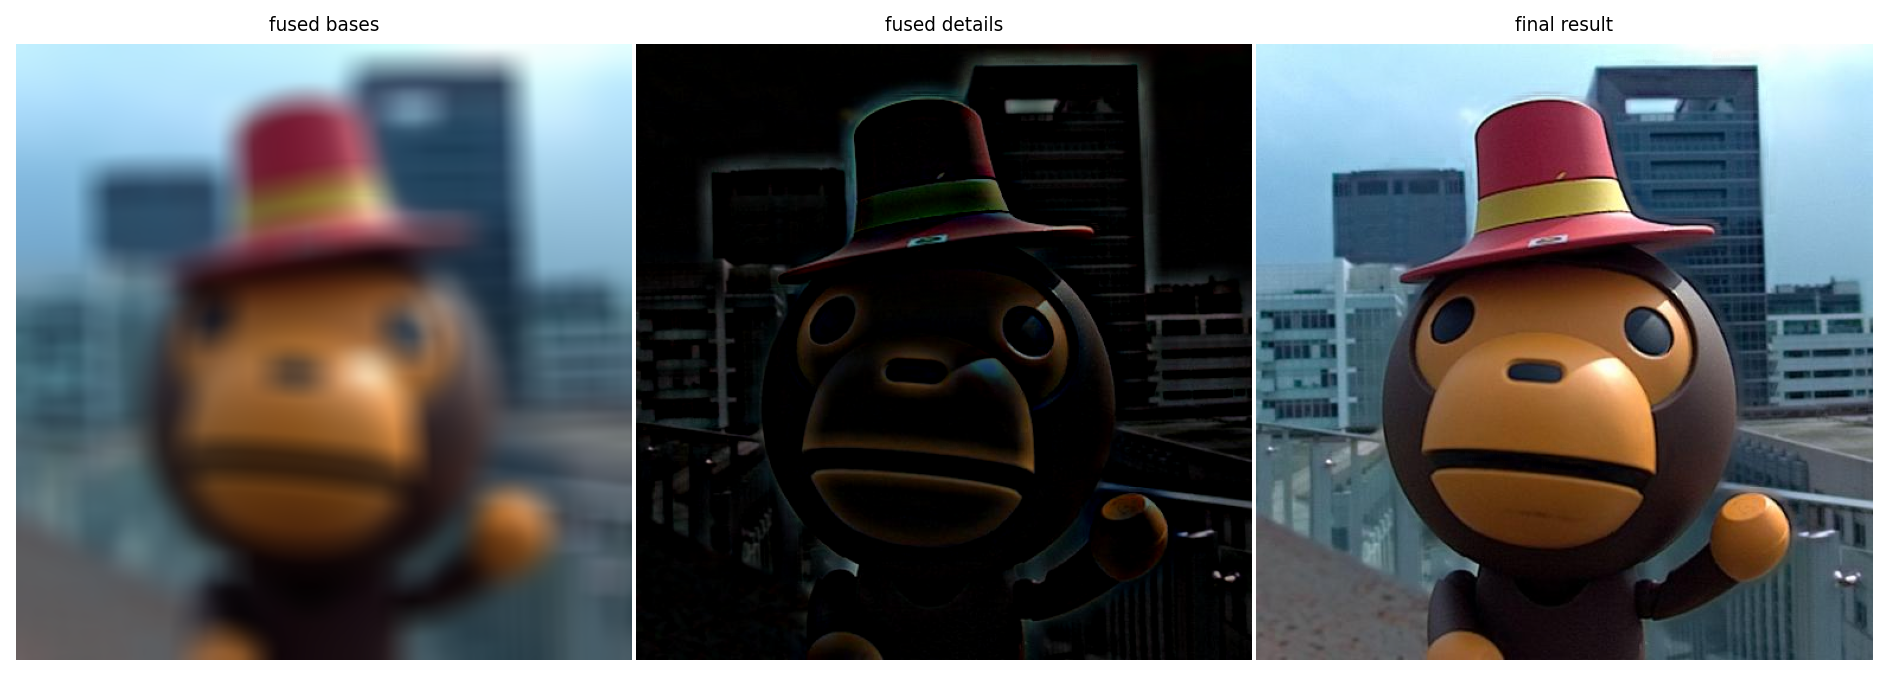

In [8]:
plot_images(gff_focus.fused["base"], gff_focus.fused["detail"], fused_focus,
            labels=['fused bases', 'fused details', 'final result'])
plt.show()

## Examples

Because the concept of *saliency* discriminates both in-focus against out-of-focus, and saturated against non-saturated, the method above can actually be used both for HDR and multi-focus recomposition.

In [9]:
exposure_gff = fusion.gff(multi_exposure_sample)
multi_exposure_fused = exposure_gff.fusion(r1=100, r2=15)

focus_gff = fusion.gff(multi_focus_sample)
multi_focus_fused = focus_gff.fusion()

gray_gff = fusion.gff(gray_sample)
multi_gray_fused = gray_gff.fusion()

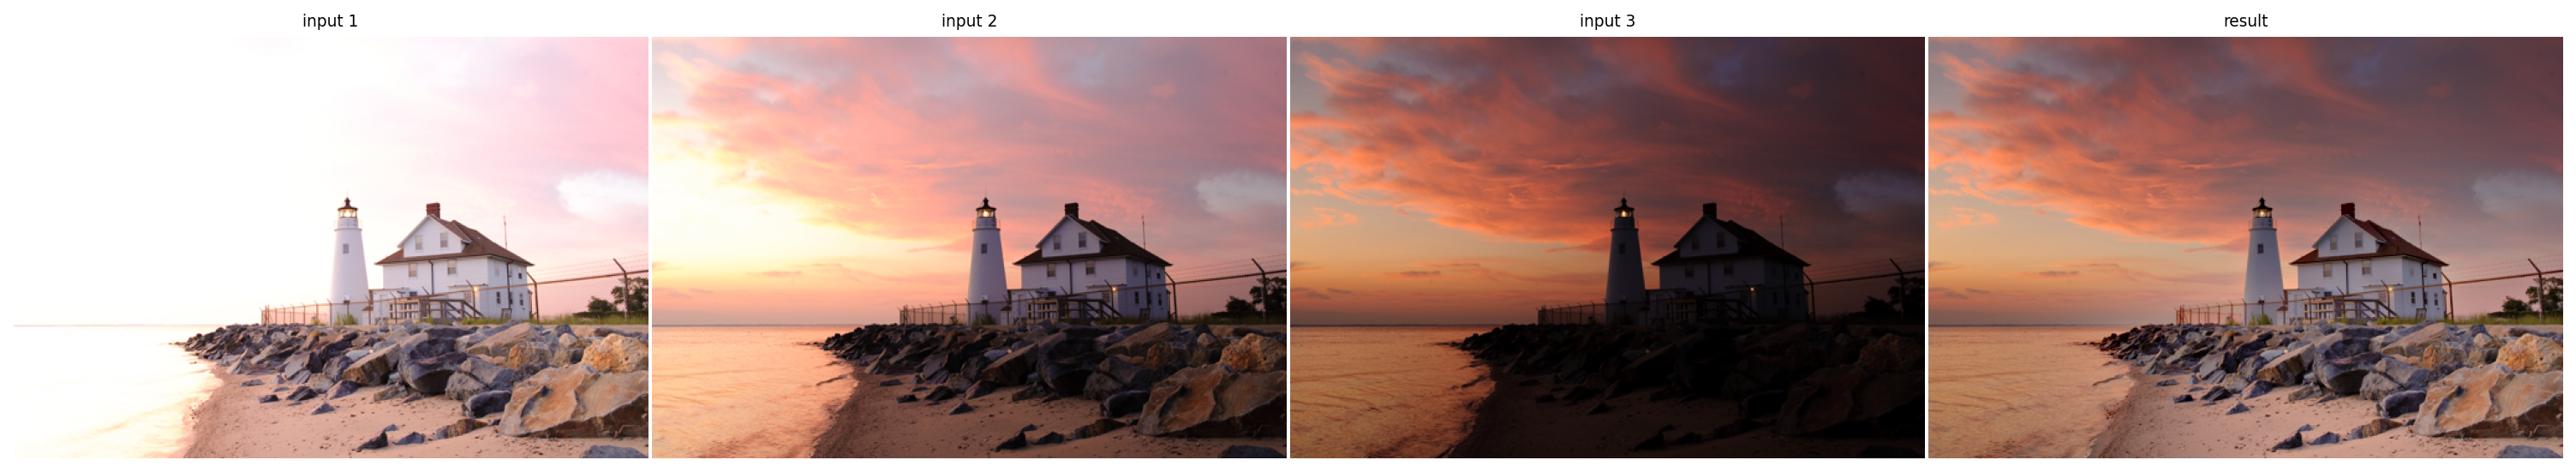

In [10]:
plot_images(*multi_exposure_sample, multi_exposure_fused,
            labels=['input 1', 'input 2', 'input 3', 'result'])
plt.show()

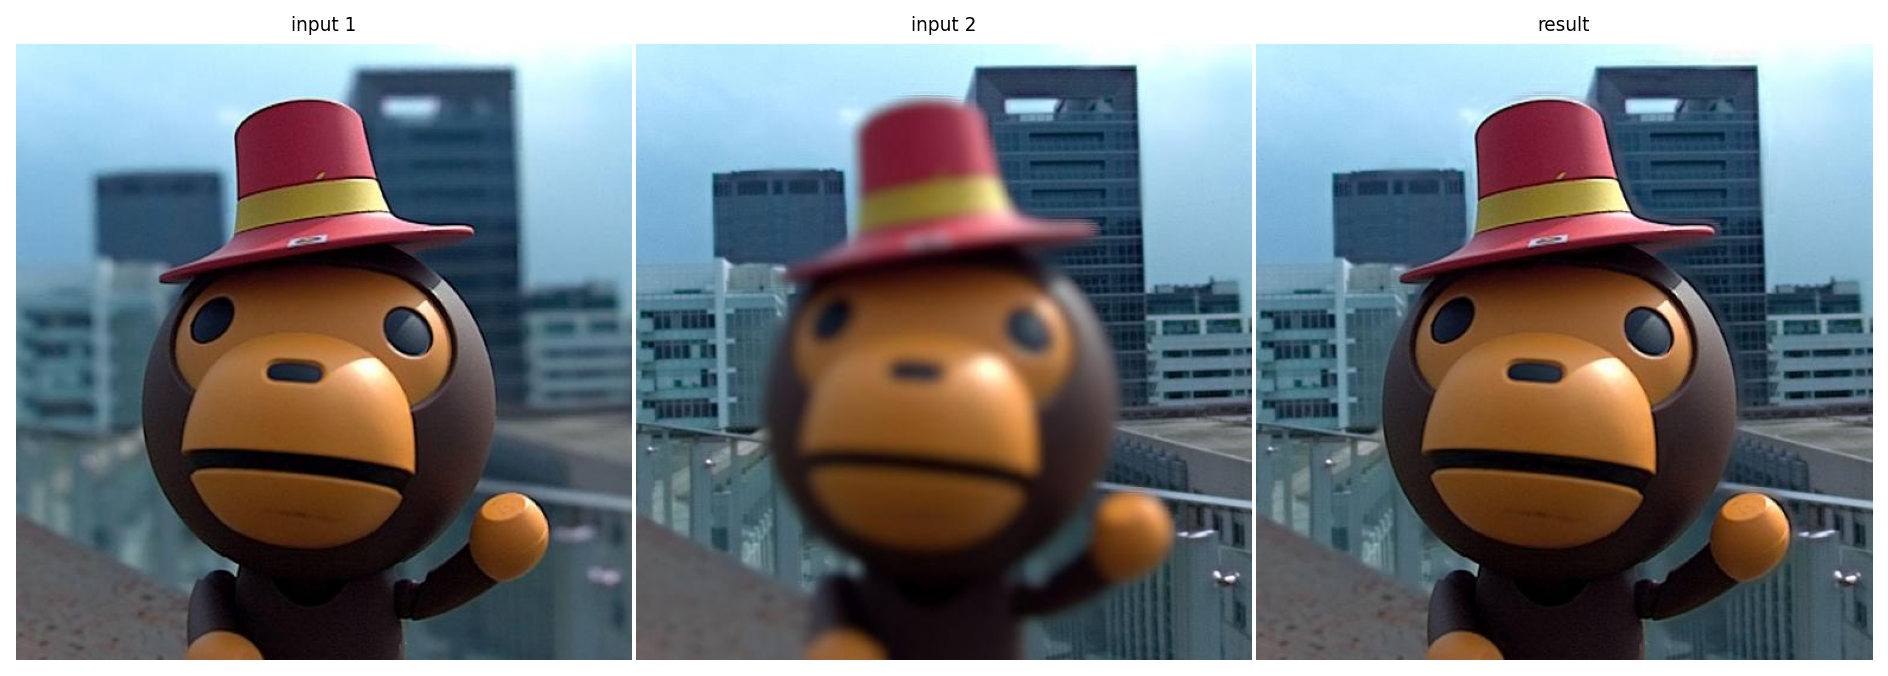

In [11]:
plot_images(*multi_focus_sample, multi_focus_fused,
            labels=['input 1', 'input 2', 'result'])
plt.show()

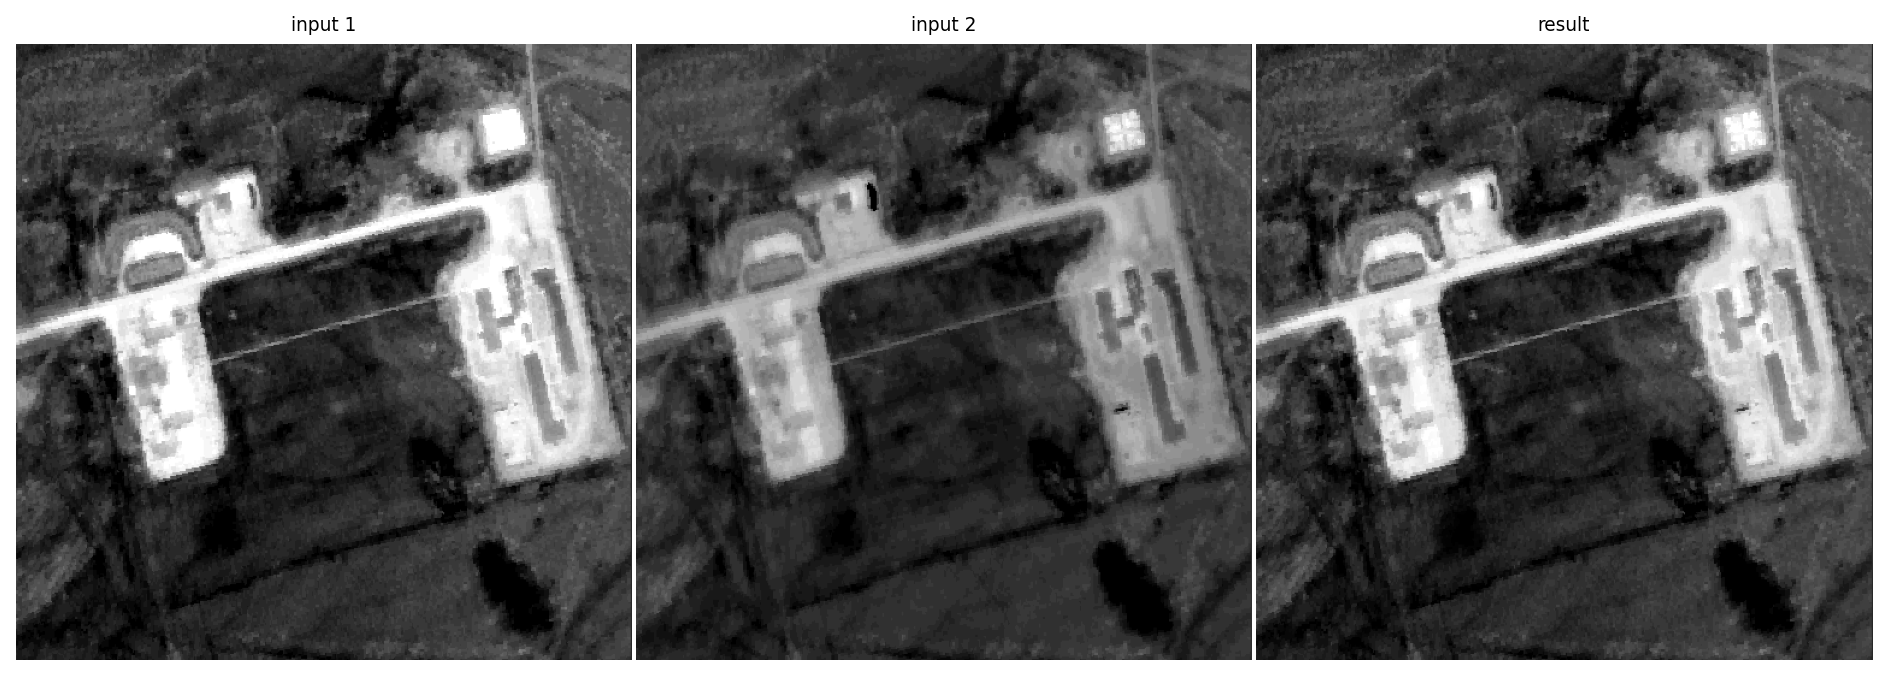

In [12]:
plot_images(*gray_sample, multi_gray_fused,
            labels=['input 1', 'input 2', 'result'])
plt.show()

## Managing out-of-bounds values

The authors do not speak about how to handle out of bounds values. Out-of-bounds may appear during two steps:

1. When applying the **guided filters**, there is no guarantee that the output will stay either in the input image or guidance image bounds. It seems reasonable to clip the filtered weights between 0 and 1, otherwise we cannot normalize the weights in a meaningful way.

2. When **recombining** the base and detail layer, we can also get out-of-bounds values. Simply rescaling the output may noticeably "grayify" the image if there are values in the output too far out of bounds. We chose to also clip the image instead.